
# Ejercicio de exploración de datos de la Liga Mexicana de Beisbol temporadas 2006-2009

### Extracción de datos

In [83]:
%matplotlib inline

from requests import post
from json import loads
from functools import reduce 

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import IntegerType, StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import col, asc

import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio

import matplotlib.pyplot as plt

responses = []

# Hacemos requests a Baseball Reference para obtener las estadisticas de la temporada del 06 al 09

for i in range(2006,2020,1):
    #print(i)
    url = f"https://www.fangraphs.com/api/leaders/minor-league/data?pos=all&level=0&lg=31&stats=bat&qual=y&type=0&team=&season={i}&seasonEnd={i}&org=&ind=0&splitTeam=false"
    responses.append(post(url))




In [84]:
# Extraemos la respuesta de los requests anteriores 

json_data = []

for response in responses:
    #print(response.text)
    json_data.append(loads(response.text))

In [85]:
# Iniciamos una sesión de Spark 

spark = SparkSession.builder.appName('test').getOrCreate()

spark


In [86]:
#definimos el esquema de datos para hacer la conversión de Json a DataFrame

schema = StructType(
    [
        StructField("Name", StringType(), True),
        StructField("Team", StringType(), True),
        StructField("G", DoubleType(), True),
        StructField("AB", DoubleType(), True),
        StructField("PA", DoubleType(), True),
        StructField("H", DoubleType(), True),
        StructField("1B", DoubleType(), True),
        StructField("2B", DoubleType(), True),
        StructField("3B", DoubleType(), True),
        StructField("HR", DoubleType(), True),
        StructField("R", DoubleType(), True),
        StructField("RBI", DoubleType(), True),
        StructField("BB", DoubleType(), True),
        StructField("IBB", DoubleType(), True),
        StructField("SO", DoubleType(), True),
        StructField("HBP", DoubleType(), True),
        StructField("SF", DoubleType(), True),
        StructField("SH", DoubleType(), True),
        StructField("GDP", DoubleType(), True),
        StructField("SB", DoubleType(), True),
        StructField("CS", DoubleType(), True),
        StructField("AVG", DoubleType(), True),
        StructField("BB%", DoubleType(), True),
        StructField("K%", DoubleType(), True),
        StructField("BB/K", DoubleType(), True),
        StructField("OBP", DoubleType(), True),
        StructField("SLG", DoubleType(), True),
        StructField("OPS", DoubleType(), True),
        StructField("ISO", DoubleType(), True),
        StructField("Spd", DoubleType(), True),
        StructField("BABIP", DoubleType(), True),
        StructField("wRC", DoubleType(), True),
        StructField("wRAA", DoubleType(), True),
        StructField("wOBA", DoubleType(), True),
        StructField("wRC+", DoubleType(), True),
        StructField("wBsR", DoubleType(), True),
        StructField("GB%", DoubleType(), True),
        StructField("LD%", DoubleType(), True),
        StructField("FB%", DoubleType(), True),
        StructField("IFFB%", DoubleType(), True),
        StructField("HR/FB", DoubleType(), True),
        StructField("GB/FB", DoubleType(), True),
        StructField("Oppo%", DoubleType(), True),
        StructField("Pull%", DoubleType(), True),
        StructField("Cent%", DoubleType(), True),
        StructField("Balls", DoubleType(), True),
        StructField("Strikes", DoubleType(), True),
        StructField("Pitches", DoubleType(), True),
        StructField("SwStr%", DoubleType(), True),
        StructField("Age", StringType(), True),
        StructField("MaxAge", IntegerType(), True),
        StructField("Season", IntegerType(), True),
        StructField("PlayerName", StringType(), True),
        StructField("TeamName", StringType(), True),
        StructField("AffId", StringType(), True),
        StructField("AffAbbName", StringType(), True),
        StructField("aLevel", StringType(), True),
        StructField("playerids", StringType(), True),
        StructField("minormasterid", StringType(), True)
    ]
)

In [87]:
# Define una lista de Dataframes 
psDataframes = []

# Aplicando el esquema definido a los Json generados por las respuestas 
for data in json_data:
    df = spark.sparkContext.parallelize(data).toDF(schema)
    psDataframes.append(df)

# master_df es mi dataframe principal

master_df = reduce(DataFrame.union, psDataframes)

### Limpieza de datos.

In [88]:
# Despues de revisar los datos dicidi no usar estas columnas

to_drop = ["Name",
           "Team",
           "TeamName",
           "AffId",
           "AffAbbName",
           "aLevel",
           "playerids" 
]

master_df = master_df.drop(*to_drop)
master_df = master_df.orderBy(asc("Season"))
master_df = master_df.distinct()

## Análisis de datos y visualización

23/04/03 21:39:00 WARN DAGScheduler: Broadcasting large task binary with size 1090.0 KiB


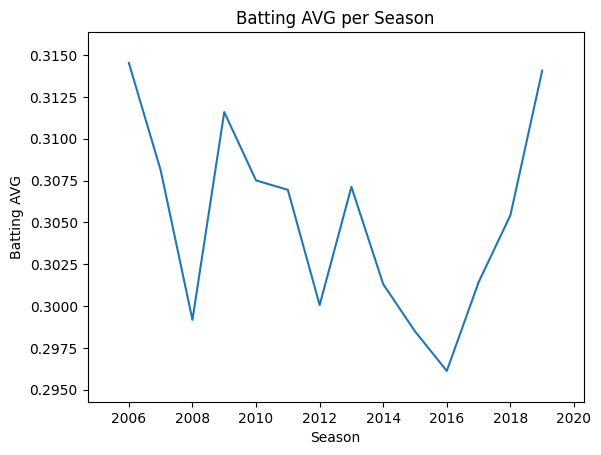

In [89]:


#year_avg_df = reduce(DataFrame.union, year_ab)
year_avg_df = master_df.select('Season','AVG').groupby('Season').mean('AVG')
year_avg_df = year_avg_df.orderBy(asc("Season"))
#year_avg_df.show()

# extract x and y values from the DataFrame
x_values = year_avg_df.select(col("Season")).rdd.flatMap(lambda x: x).collect()
y_values = year_avg_df.select(col("avg(AVG)")).rdd.flatMap(lambda x: x).collect()

# create a line plot using Matplotlib
plt.plot(x_values, y_values)

# set the axis labels and title
plt.xlabel("Season")
plt.ylabel("Batting AVG")
plt.title("Batting AVG per Season")
plt.margins(y=.1, x=.1)


# display the plot
plt.show()


23/04/03 21:39:06 WARN DAGScheduler: Broadcasting large task binary with size 1090.0 KiB


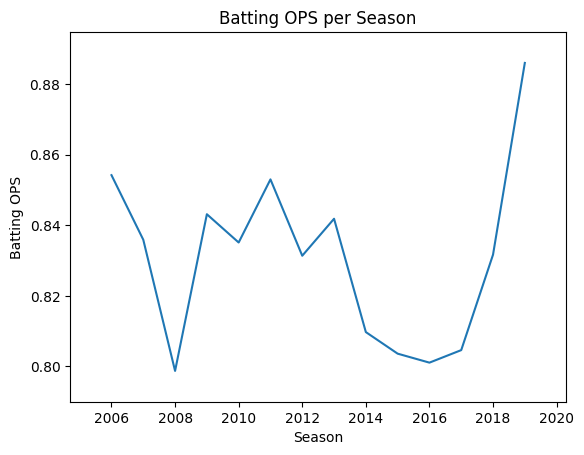

In [90]:
year_ops_df = master_df.select('Season','OPS').groupby('Season').mean('OPS')
year_ops_df = year_ops_df.orderBy(asc("Season"))
#year_ops_df.show()

# extract x and y values from the DataFrame
x_values = year_ops_df.select(col("Season")).rdd.flatMap(lambda x: x).collect()
y_values = year_ops_df.select(col("avg(OPS)")).rdd.flatMap(lambda x: x).collect()

# create a line plot using Matplotlib
plt.plot(x_values, y_values)

# set the axis labels and title
plt.xlabel("Season")
plt.ylabel("Batting OPS")
plt.title("Batting OPS per Season")
plt.margins(y=.1, x=.1)


# display the plot
plt.show()


23/04/03 21:39:12 WARN DAGScheduler: Broadcasting large task binary with size 1090.0 KiB


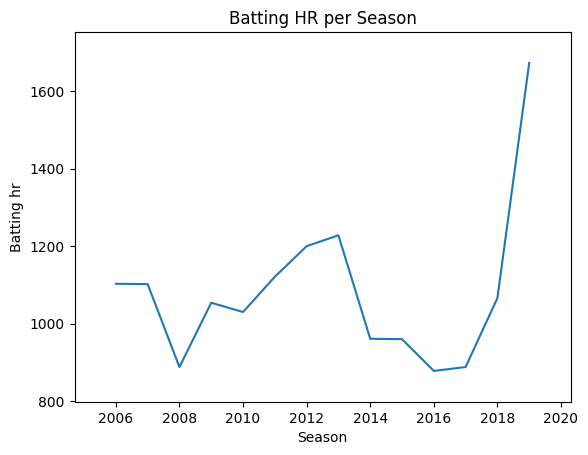

In [91]:
year_hr_df = master_df.select('Season','HR').groupBy('Season').sum('HR')
year_hr_df = year_hr_df.orderBy(asc("Season"))
#year_hr_df.show()

# extract x and y values from the DataFrame
x_values = year_hr_df.select(col("Season")).rdd.flatMap(lambda x: x).collect()
y_values = year_hr_df.select(col("sum(HR)")).rdd.flatMap(lambda x: x).collect()

# create a line plot using Matplotlib
plt.plot(x_values, y_values)

# set the axis labels and title
plt.xlabel("Season")
plt.ylabel("Batting hr")
plt.title("Batting HR per Season")
plt.margins(y=.1, x=.1)
# display the plot
plt.show()



23/04/03 21:39:19 WARN DAGScheduler: Broadcasting large task binary with size 1090.0 KiB


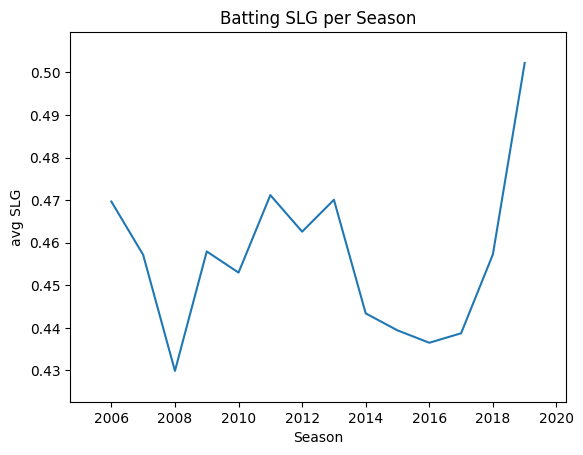

In [92]:
year_slg_df = master_df.select('Season','SLG').groupBy('Season').mean('SLG')
year_slg_df = year_slg_df.orderBy(asc("Season"))
#year_slg_df.show()

# extract x and y values from the DataFrame
x_values = year_slg_df.select(col("Season")).rdd.flatMap(lambda x: x).collect()
y_values = year_slg_df.select(col("avg(SLG)")).rdd.flatMap(lambda x: x).collect()

# create a line plot using Matplotlib
plt.plot(x_values, y_values)

# set the axis labels and title
plt.xlabel("Season")
plt.ylabel("avg SLG")
plt.title("Batting SLG per Season")
plt.margins(y=.1, x=.1)
# display the plot
plt.show()

In [93]:
player_wrc_df = master_df.select('PlayerName','wRC+').groupBy('PlayerName').avg('wRC+')
#player_wrc_df.show()
fig = px.bar(player_wrc_df.toPandas(), x='PlayerName', y='avg(wRC+)',title='wRC+ promedio por jugador')
pio.write_image(fig, './images/wRC+ promedio por jugador.png')
fig.show()
# extract x and y values from the DataFrame
#master_df.select('PlayerName','wRC+').groupBy('PlayerName').avg('wRC+').count()


23/04/03 21:39:22 WARN DAGScheduler: Broadcasting large task binary with size 1090.0 KiB


In [94]:

bat_stats_df = master_df.select('Season','AVG','OBP','SLG','BABIP','SO','BB').groupBy('Season').avg('AVG','OBP','SLG','BABIP')
bat_stats_df = bat_stats_df.orderBy(asc("Season"))
#bat_stats_df.show()

bat_stats_df = bat_stats_df.sort('Season').toPandas()

fig = go.Figure()
fig.add_trace(go.Scatter(x= bat_stats_df['Season'], y= bat_stats_df['avg(AVG)'],
                    mode='lines',
                    name='avg'))

fig.add_trace(go.Scatter(x= bat_stats_df['Season'], y= bat_stats_df['avg(OBP)'],
                    mode='lines',
                    name='obp'))

#fig.add_trace(go.Scatter(x= bat_stats_df['Season'], y= bat_stats_df['avg(SLG)'],
#                    mode='lines',
#                    name='slg'))

fig.add_trace(go.Scatter(x= bat_stats_df['Season'], y= bat_stats_df['avg(BABIP)'],
                    mode='lines',
                    name='babip'))
pio.write_image(fig, './images/comparacion avg-obp-babip.png')
fig.show()


23/04/03 21:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1090.0 KiB


In [95]:
bat_stats_df = master_df.select('PlayerName','Season','wRC+')
bat_stats_df = bat_stats_df.toPandas()

fig = px.scatter(bat_stats_df, x="Season", y="wRC+", hover_data="PlayerName",title='wRC+por temporada')
pio.write_image(fig, './images/wRC+por temporada.png')
fig.show()

23/04/03 21:39:28 WARN DAGScheduler: Broadcasting large task binary with size 1090.0 KiB


In [96]:
bat_stats_df = master_df.select('Season','HR','2B','3B').groupBy('Season').sum('HR','2B','3B')
#bat_stats_df.show()
bat_stats_df = bat_stats_df.toPandas()

fig = px.bar(bat_stats_df, x="Season", y=["sum(HR)","sum(2B)","sum(3B)"], title="Distribucion extrabases")
pio.write_image(fig, './images/Distribucion extrabases.png')
fig.show()

23/04/03 21:39:32 WARN DAGScheduler: Broadcasting large task binary with size 1090.0 KiB
